<a href="https://colab.research.google.com/github/VaibhavN007/Notebooks/blob/master/PSR_Stress_Test_Outlier_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
from numpy.random import seed
from numpy.random import randn
from numpy import percentile, array, linspace, argmax, sort
import numpy as np

from sklearn.neighbors.kde import KernelDensity
# from sklearn.grid_search import GridSearchCV
# from sklearn.cross_validation import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

import matplotlib.pyplot as plt
import math
import pandas as pd
from google.colab import files
import io

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
uploaded = files.upload()

Saving signals PO-YES timestamp-2020-09-03 18-22.csv to signals PO-YES timestamp-2020-09-03 18-22.csv


In [3]:
df = pd.read_csv(io.BytesIO(uploaded['signals PO-YES timestamp-2020-09-03 18-22.csv']))
df.RelatedObjectType = df.RelatedObjectType.fillna(0)

In [4]:
df_verified = df.loc[ df.SignalVerified == True ]

In [5]:
df_verified_grouped = [g for _, g in df_verified.groupby(['ObjectType', 'RelatedObjectType', 'EventType'])]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

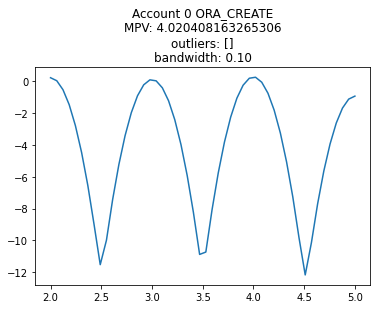

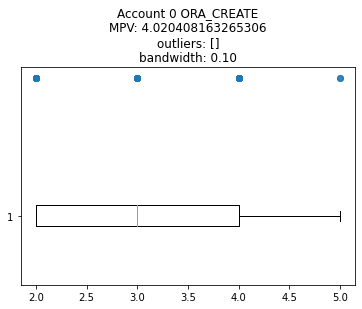

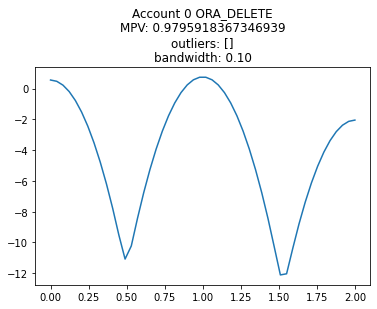

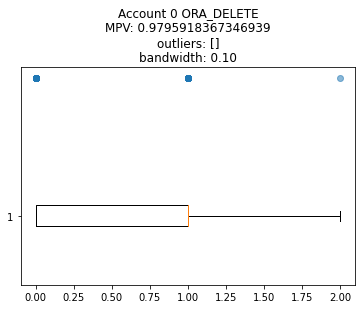

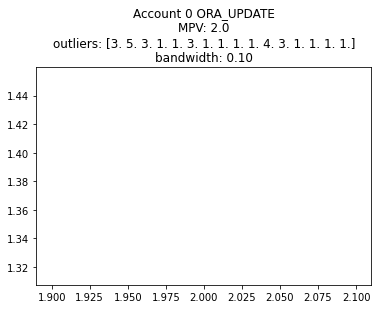

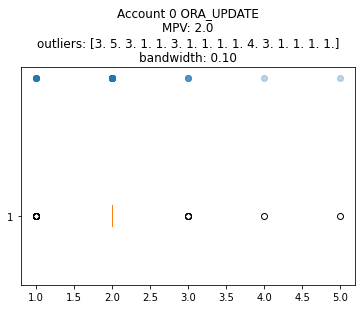

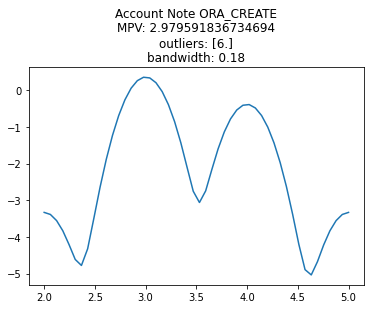

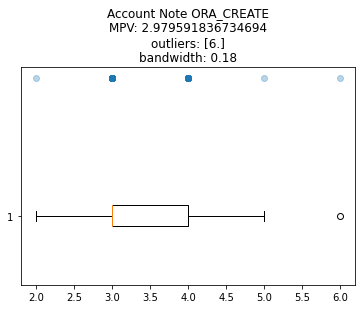

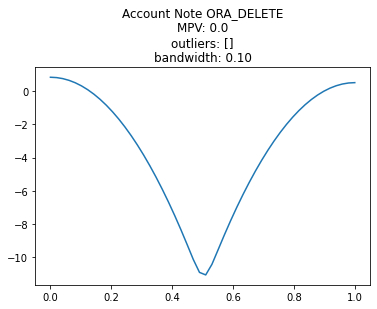

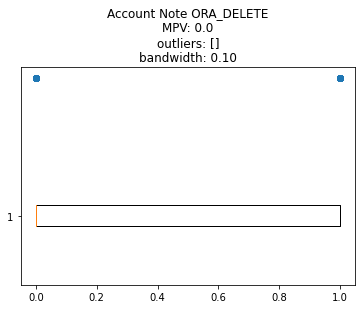

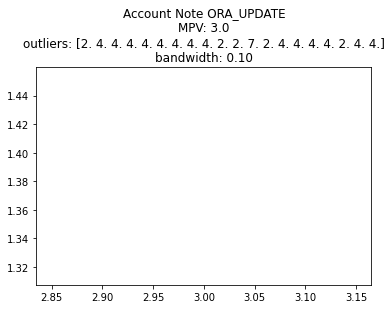

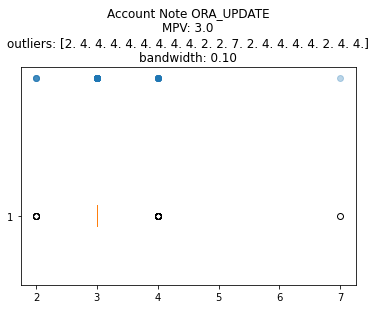

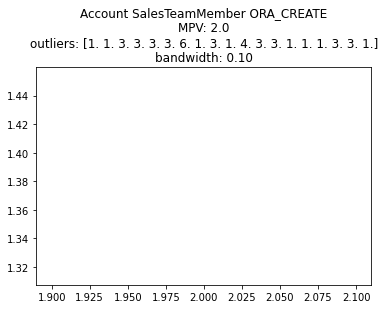

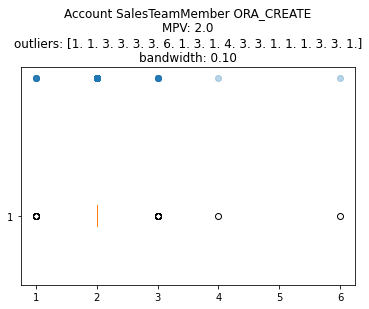

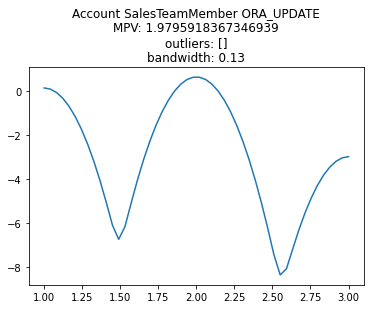

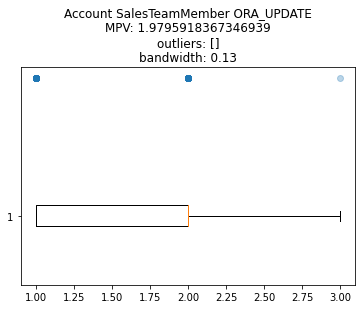

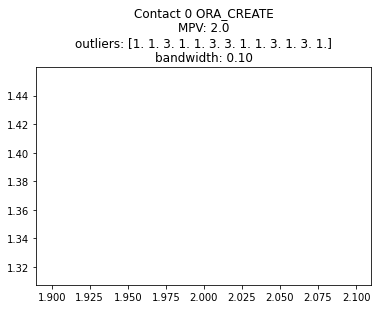

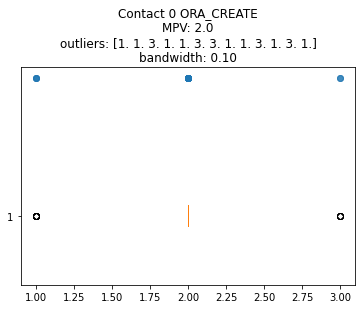

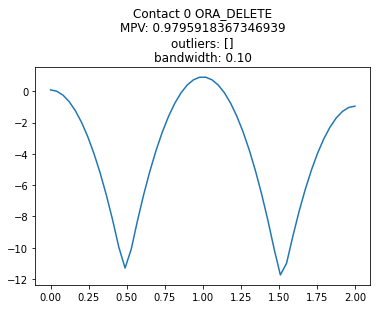

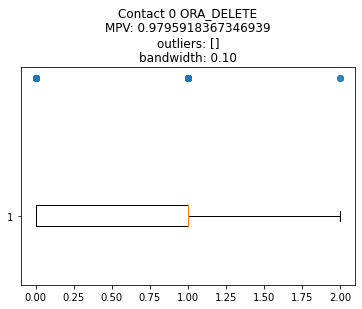

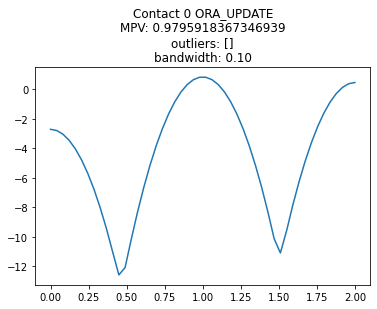

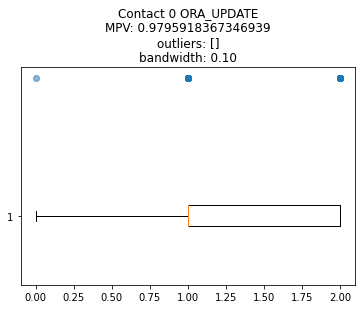

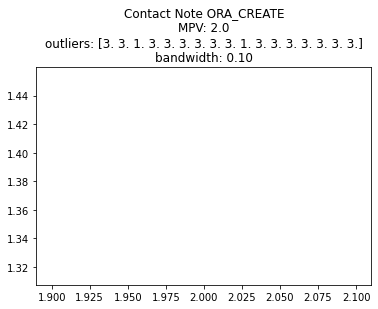

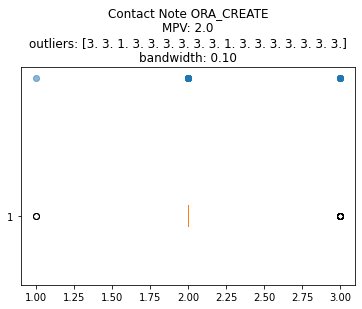

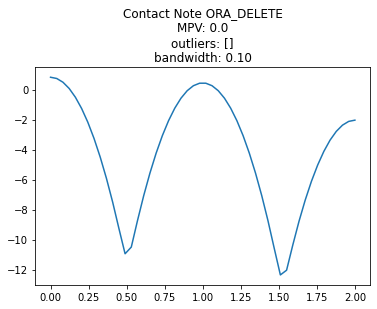

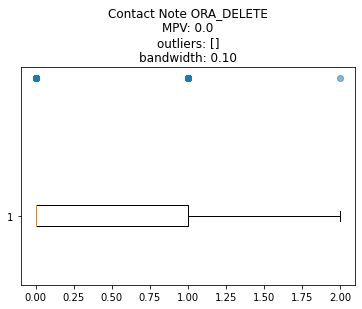

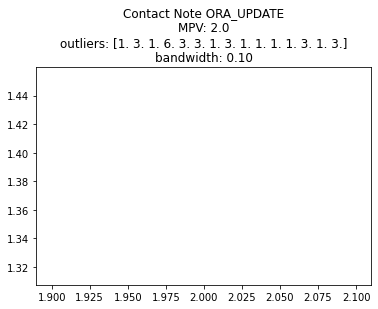

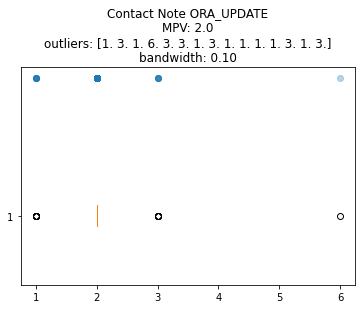

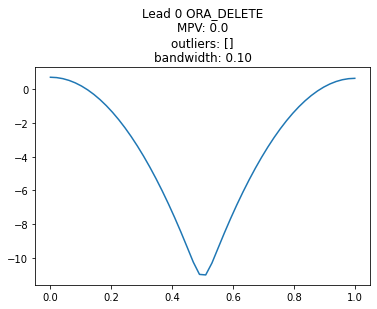

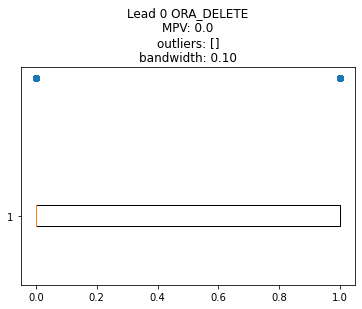

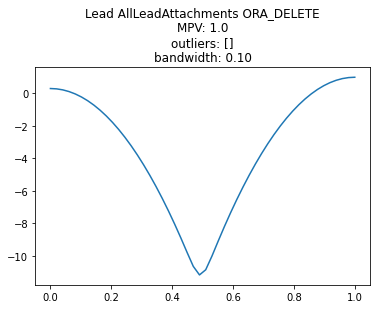

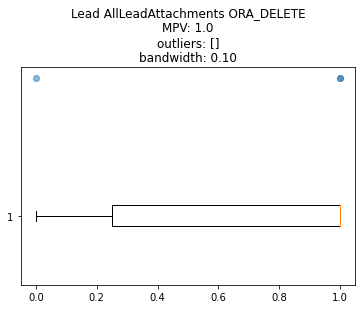

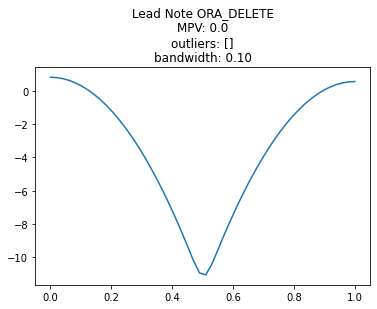

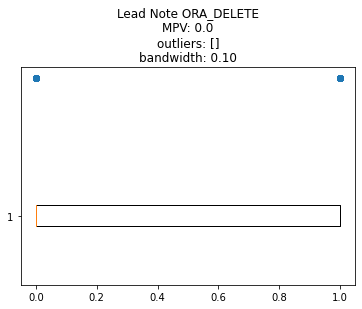

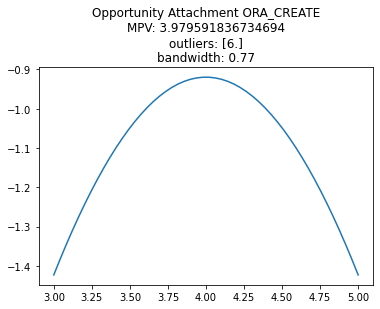

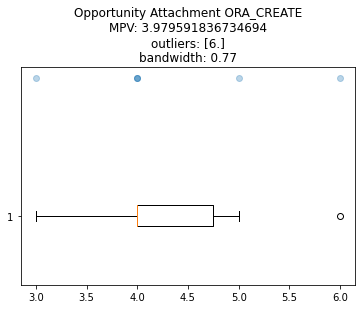

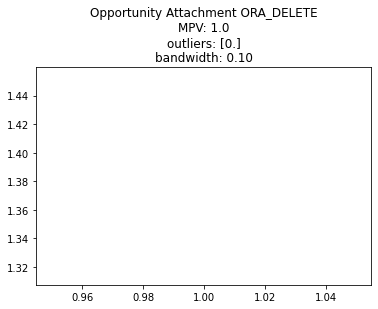

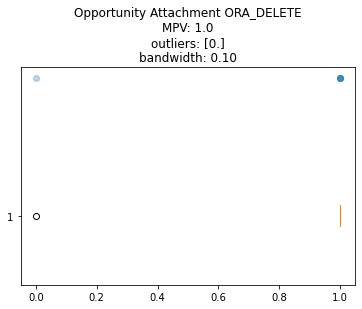

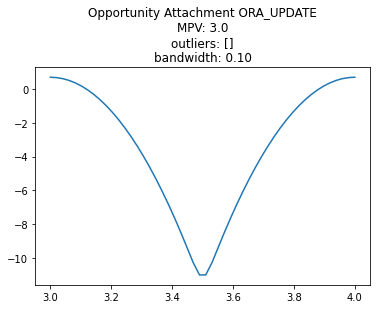

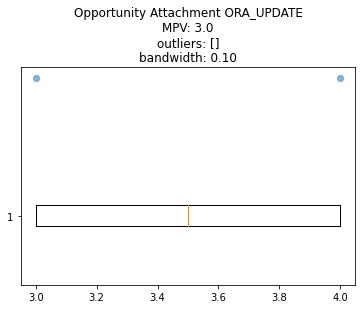

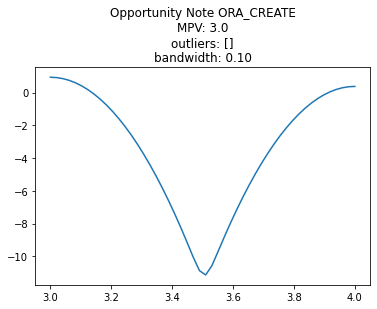

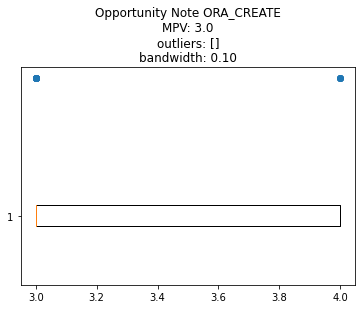

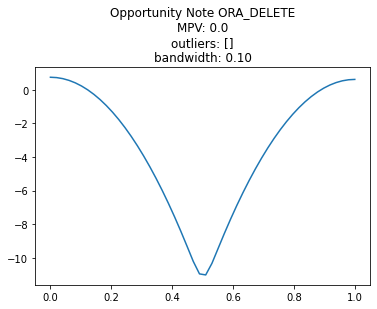

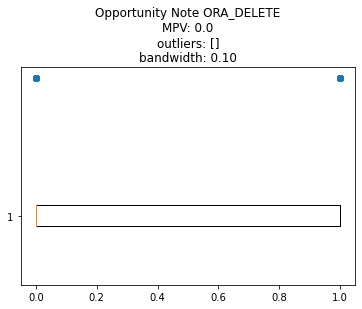

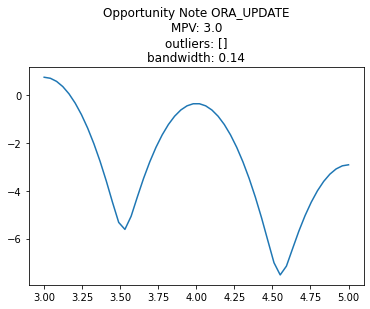

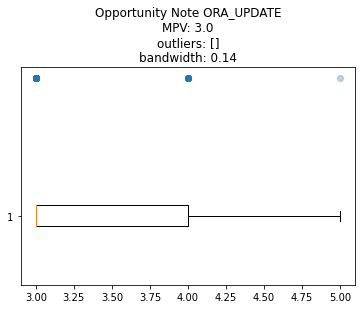

In [6]:
loo = LeaveOneOut()

for df_group in df_verified_grouped:
    data = df_group.SignalDelay
    # calculate interquartile range
    q25, q75 = percentile(data, 25), percentile(data, 75)
    iqr = q75 - q25
    # print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))

    # calculate the outlier cutoff
    whis = 1.5
    cut_off = iqr * whis
    lower, upper = q25 - cut_off, q75 + cut_off

    # identify outliers
    outliers = array([x for x in data if x < lower or x > upper])
    # print("outliers:", outliers)

    # remove outliers
    outliers_removed = array([x for x in data if x >= lower and x <= upper])
    # print("outliers removed:", outliers_removed)

    # print("std deviation:", np.round(np.std(outliers_removed), decimals=2))

    # calculate most probable value using Kernel Density Estimation (KDE)
    # first calculate the hyperparameter required for KDE which is bandwidth
    bandwidths = 10 ** np.linspace(-1, 1, 100)
    grid = GridSearchCV( KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidths},
                        cv = loo.get_n_splits(outliers_removed) )
    
    grid.fit(outliers_removed[:,None])
    kde = grid.best_estimator_
    # print("best bandwidth:", grid.best_params_)

    # uncomment the following line to use a hardcoded bandwidth version of KDE
    # kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(outliers_removed[:,None])

    x = linspace( min(outliers_removed) , max(outliers_removed) )
    y = kde.score_samples(x.reshape(-1,1))
    mpv = x[argmax(y)]

    # uncomment the following line to plot the KDE fit function
    fig, ax = plt.subplots()
    ax.set_title( "{0} {1} {2}\nMPV: {3}\noutliers: {4}\nbandwidth: {5:.2f}".format(
        df_group.ObjectType.iloc[0], 
        df_group.RelatedObjectType.iloc[0], 
        df_group.EventType.iloc[0], 
        mpv, 
        outliers,
        grid.best_params_.get('bandwidth')
    ))
    ax.plot(x, y)

    # boxplot of outliers
    fig1, ax1 = plt.subplots()
    ax1.set_title( "{0} {1} {2}\nMPV: {3}\noutliers: {4}\nbandwidth: {5:.2f}".format(
        df_group.ObjectType.iloc[0], 
        df_group.RelatedObjectType.iloc[0], 
        df_group.EventType.iloc[0], 
        mpv, 
        outliers,
        grid.best_params_.get('bandwidth')
    ))
    ax1.boxplot(data, vert=False, whis=whis)
    ax1.scatter( data, np.full(data.shape, 2), alpha=0.3)

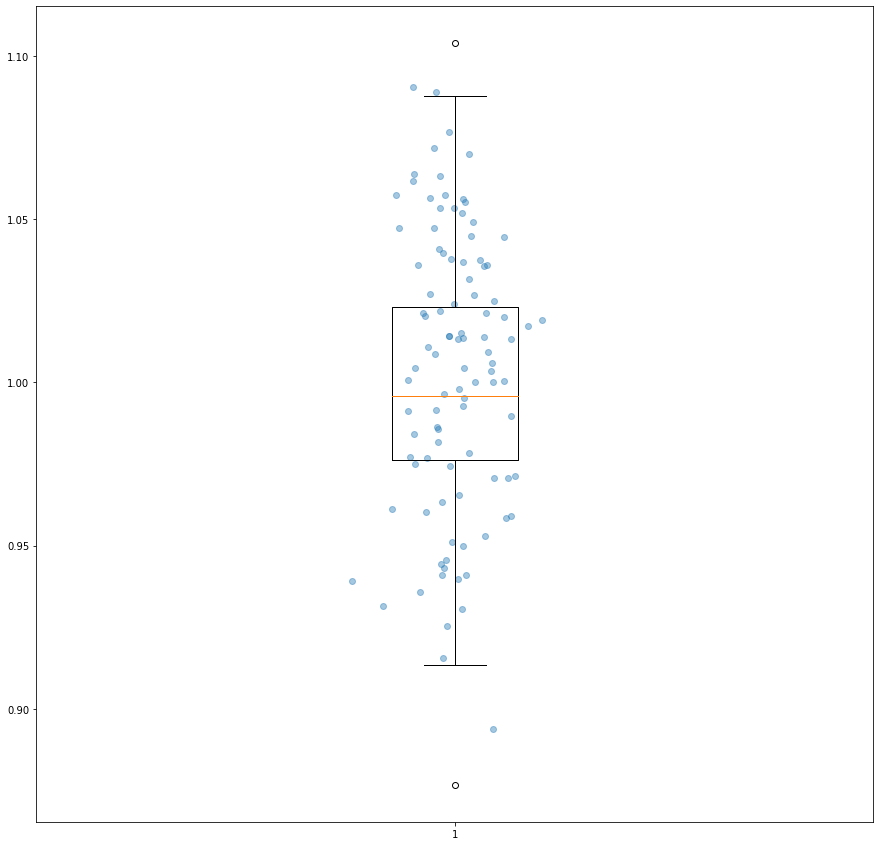

In [12]:
fig1, ax1 = plt.subplots(figsize=(15,15))
xs = np.random.normal(1, 0.04, (100,))
ys = np.random.normal(1, 0.04, (100,))

ax1.boxplot(xs)
ax1.scatter( xs, ys, alpha=0.4)